<a href="https://colab.research.google.com/github/urvashiverma2608/Projectsecure/blob/master/Practical4_TextAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text classification with LR, NB and SVM

Document/Text classification is one of the important and typical task in supervised machine learning (ML), with many applications such as spam filtering, email routing, sentiment analysis. 

In this worksheet we will go through a text based sentiment analysis using some linear and nonlinear models. We will learn how to extract features from text. 

We also peform grid search and randomized search for tuning the hyperparameters for support vector machines. Randomised search is often more efficient (requires much less run time) than grid search when it comes to hyperparameter tuning search, see [the comparison](https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html)



**Be aware that** It might take too long and too much memory to train and tune the hyperparameters for standard SVMs, if working on local machines (in B57) given the large sample size for this dataset. Note that, a kernel matrix of size n*n is to be constructued for SVM training (n is the number of training samples). On the other hand, SVMs would be quite useful to work with problems with n samples and d variables and n << d

Here's the documentation for the SVM in sklearn:
- https://scikit-learn.org/stable/modules/svm.html

Please familarise yourself with the idea of examining documentation without prompt as you need to get used to it for your assignment and future data science work.

This worksheet was adapted from Eugen Anghel's [python notebook](https://www.kaggle.com/eugen1701/predicting-sentiment-and-helpfulness/data)

# Sentiment analysis using Amazon review dataset

We will be reviewing a Kaggle featured dataset of over 500k Amazon customer food reviews, provided by Stanford Network Analysis Project. Our aim is to develop models for predicting whether a customer review message is positive or negative. We will not focus on the Score, but only the positive/negative sentiment of the recommendation. 

We will go through several key steps for this machine learning task:

- Extracting features from text files, such as **bag of words** and **Term Frequency - Inverse Document Frequency** (TF-IDF).
- Splitting data into **training/validation/testing**
- Fitting Naive Bayes, logistic regression, and SVM models
- Evaluating model performance using **ROC analysis**
- Selecting hyperparameters and models using Scikit-learn pipeline and **grid search** based on validation set
- Making prediction on the test set, and evaluate
- Examining important features for the prediction


In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc



## Loading the data
In order to load the data, we will use the SQLITE dataset where we will only fetch the Score and the recommendation summary. 
For more detailed description of the data, please see: 
http://snap.stanford.edu/data/web-FineFoods.html

As we only want to get the global sentiment of the review (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "postive". Otherwise, it will be set to "negative". 

The data will be split into an training set and a test set with a test set ratio of (e.g.) 0.2

Let's first check whether we have the dataset available:

In [2]:
# For google colab user only. You can mount your google drive, and use the folder
# as in any virtual machine. 
# You can also explore your good drive by clicking [folder icon] in the menu 
#  to left of the colab notebook
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


In [5]:
# Change the directory appropriate to you
dir = '/content/gdrive/MyDrive/Reviews.csv'
messages = pd.read_csv(os.path.join(dir), sep=",")
#messages = pd.read_csv("/content/gdrive/MyDrive/CSM6420-2023/data/review10k.csv", sep=',')

messages.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [6]:
# Only pick columns of interest, and rename a few columns
dir = '/content/gdrive/MyDrive/Reviews.csv'
messages = pd.read_csv(os.path.join(dir), sep=",")

messages = messages[["Score", "Summary","HelpfulnessNumerator","HelpfulnessDenominator"]]
messages = messages.rename(columns={"HelpfulnessNumerator": "VotesHelpful", "HelpfulnessDenominator": "VotesTotal"})


In [7]:
messages.describe(include='all')

,Score,Summary,VotesHelpful,VotesTotal
count,568454.000000,568427,568454.000000,568454.00000
unique,NaN,295742,NaN,NaN
top,NaN,Delicious!,NaN,NaN
freq,NaN,2462,NaN,NaN
mean,4.183199,NaN,1.743817,2.22881
std,1.310436,NaN,7.636513,8.28974
min,1.000000,NaN,0.000000,0.00000
25%,4.000000,NaN,0.000000,0.00000
50%,5.000000,NaN,0.000000,1.00000
75%,5.000000,NaN,2.000000,2.00000


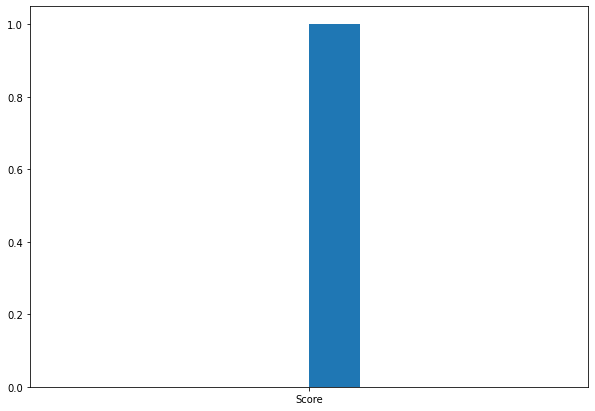

In [10]:
# Your code here: 
# Check the distribution of the score (histogram)
from matplotlib import pyplot as plt
import numpy as np
 
 
# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist("Score")
 
# Show plot
plt.show()

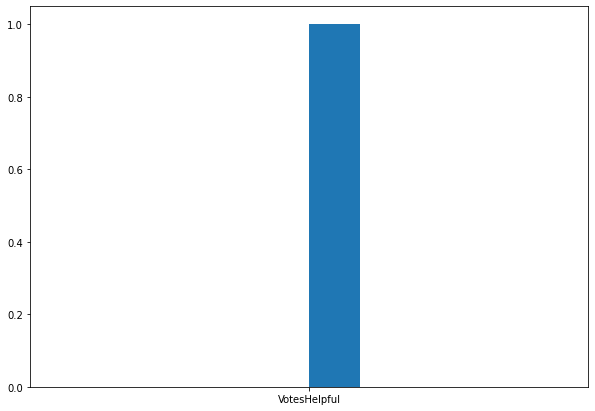

In [11]:
# You code here:
# Check the distribution of VotesHelpful. 
# Hint: Some data transformation might be needed 
from matplotlib import pyplot as plt
import numpy as np
 
 
# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist("VotesHelpful")
 
# Show plot
plt.show()



Now let's select only what's of interest to us:

In [12]:
messages = messages[messages.Score!=3]

Let's see what we've got:

In [13]:
messages.head(10)

,Score,Summary,VotesHelpful,VotesTotal
0,5,Good Quality Dog Food,1,1
1,1,Not as Advertised,0,0
2,4,"""Delight"" says it all",1,1
3,2,Cough Medicine,3,3
4,5,Great taffy,0,0
5,4,Nice Taffy,0,0
6,5,Great! Just as good as the expensive brands!,0,0
7,5,"Wonderful, tasty taffy",0,0
8,5,Yay Barley,1,1
9,5,Healthy Dog Food,0,0


Let's add the **Sentiment** column that turns the numeric score into either *positive*=1 or *negative* =0.

In [14]:
messages["Sentiment"] = messages["Score"].apply(lambda x: 1 if x > 3 else 0)
messages["Sentiment"] = messages["Sentiment"]
messages.head(10)

,Score,Summary,VotesHelpful,VotesTotal,Sentiment
0,5,Good Quality Dog Food,1,1,1
1,1,Not as Advertised,0,0,0
2,4,"""Delight"" says it all",1,1,1
3,2,Cough Medicine,3,3,0
4,5,Great taffy,0,0,1
5,4,Nice Taffy,0,0,1
6,5,Great! Just as good as the expensive brands!,0,0,1
7,5,"Wonderful, tasty taffy",0,0,1
8,5,Yay Barley,1,1,1
9,5,Healthy Dog Food,0,0,1


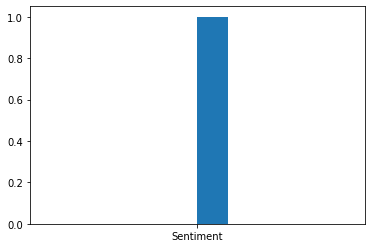

In [18]:
# Your code here:
# Check the distribution of Sentifment and Usefulness
from matplotlib import pyplot as plt
import numpy as np
 
 
# Creating histogram
fig, ax = plt.subplots()
ax.hist("Sentiment")
 
# Show plot
plt.show()


Let's have a look at some 5s:

In [16]:
messages[messages.Score == 5].head(10)

,Score,Summary,VotesHelpful,VotesTotal,Sentiment
0,5,Good Quality Dog Food,1,1,1
4,5,Great taffy,0,0,1
6,5,Great! Just as good as the expensive brands!,0,0,1
7,5,"Wonderful, tasty taffy",0,0,1
8,5,Yay Barley,1,1,1
9,5,Healthy Dog Food,0,0,1
10,5,The Best Hot Sauce in the World,1,1,1
11,5,"My cats LOVE this ""diet"" food better than thei...",4,4,1
14,5,Strawberry Twizzlers - Yummy,4,5,1
15,5,"Lots of twizzlers, just what you expect.",4,5,1


And some 1s as well:

In [17]:
messages[messages.Score == 1].head(10)

,Score,Summary,VotesHelpful,VotesTotal,Sentiment
1,1,Not as Advertised,0,0,0
12,1,My Cats Are Not Fans of the New Food,1,1,0
26,1,Nasty No flavor,0,1,0
50,1,Don't like it,0,7,0
62,1,stale product.,2,2,0
73,1,Warning! WARNING! -ALCOHOL SUGARS!,0,1,0
75,1,No Tea Flavor,0,0,0
99,1,Bad,0,1,0
153,1,Rip off Price,1,1,0
164,1,Tasteless but low calorie,0,4,0


## Extracting features from text data

Text data are usually series of ordered words, which need to be converted to numerical features before feeding to machine learning algorithms. 

- **Bag of words**: Bag of words model is one popular representation for text, in which we segment each text file (one English review mesage separated by space in this case) into words, and count # of times each word occurs in each document and finally assign each word an integer id. Each unique word in our dictionary will correspond to a feature (descriptive feature).

- **TF** (Term Frequency): Just counting the number of words in each document has 1 issue: it will give more weights to longer documents than shorter documents. To avoid this, we can use frequency, i.e. TF = #count of word / #Total words, in each document.

- **TF-IDF** (Term Frequency times Inverse Document Frequency): Finally, we can even reduce the weight of more common words like (the, is, an etc.) which occurs in most document. This is called TF-IDF i.e Term Frequency times inverse document frequency, where inverse document frequency = log(#Total docs / #count of doc containing word). See: https://en.wikipedia.org/wiki/Tf%E2%80%93idf 

Scikit-learn has a high level component which will create such feature vectors for us ‘CountVectorizer’ and 'TfidfTransformer'. 
http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

See more here: http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

In [22]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import re #regular expression module
import string
#import nltk # natural languaage toolkit (https://www.nltk.org/)

cleanup_re = re.compile('[^a-z]+') #string that contains lowcase alphabets only
def cleanup(sentence):
    sentence = cleanup_re.sub(' ', sentence).strip()
    #sentence = " ".join(nltk.word_tokenize(sentence))
    return sentence

messages["Summary_Clean"] = messages["Summary"].apply(cleanup)

TypeError: ignored

In [23]:
# Your code here:
# Check the first 10 records of Summary and Summary_Clean (to understand the effect of cleanup)
messages[["Summary","Summary_Clean"]][0:10]

KeyError: ignored

In [24]:
# Getting the indices for splitting data into training, and test set 
#train, test = train_test_split(messages, test_size=0.2)
# Set random seed to ensure result reproducibility
# Here train, test are the indices for the examples
random_seed = 12345
train, test = train_test_split(np.arange(messages.shape[0]), test_size=0.2, random_state= random_seed)
print("%d items in training set, %d in test set" % (len(train), len(test)))

420651 items in training set, 105163 in test set


In [25]:
count_vect = CountVectorizer(min_df = 1, ngram_range = (1, 4))
X_train_counts = count_vect.fit_transform(messages.iloc[train]["Summary_Clean"])

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_test_counts = count_vect.transform(messages.iloc[test]["Summary_Clean"])
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

y_train = messages.iloc[train]["Sentiment"]
y_test = messages.iloc[test]["Sentiment"]


# Initialise the dictionary to store prediction results
prediction = dict() 

KeyError: ignored

In [26]:
# Checking dataset dimensionality 
print(X_train_counts.shape)
print(X_train_tfidf.shape)
print(X_test_counts.shape)
print(X_test_tfidf.shape)

# Get the indices of nonzero elements in the sparse matrix
rows, cols = X_train_tfidf.nonzero()
# Print the first 5 nonzero elements
print(X_train_tfidf[rows[0:5], cols[0:5]]) 

NameError: ignored

## Let's get fancy with WordClouds!

Note: just in case of missing library 'worcloud' , run the following to install it. Or otherwise you don't have to run it yourself, just look at the existing figures. 

$ conda install -c conda-forge wordcloud 

or install wordcloud uisng pip within the notebook

!pip install wordcloud

In [27]:
from wordcloud import WordCloud
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

# Check what are the listed stopwords??


In [29]:
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
show_wordcloud(" ".join(messages["Summary_Clean"]))


We can also view wordclouds for only positive or only negative entries:

In [30]:
show_wordcloud(" ".join(messages[messages.Score == 1]["Summary_Clean"]), title = "Low scoring")

KeyError: ignored

In [31]:
show_wordcloud(" ".join(messages[messages.Score == 5]["Summary_Clean"]), title = "High scoring")

KeyError: ignored

## Applying Multinomial Naïve Bayes

Note: to computer AUC, we need to return a continous score or a probability output using e.g. predict_proba, which will return often multiple columnns for different classes. 

In [32]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB().fit(X_train_tfidf, y_train)

prediction['Multinomial'] = nb.predict_proba(X_test_tfidf)[:,1]


NameError: ignored

## Applying Logistic regression

In [33]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()#(C=1e3)
lr=logreg.fit(X_train_tfidf, y_train)
prediction['Logistic'] = logreg.predict_proba(X_test_tfidf)[:,1]


NameError: ignored

## Applying Support Vector Machines and Randomised Search

** It is fine to skip SVM or replace ** SVMs with random forests or other types of classifiers. 

To speed up the experiments here, you can start with just a [linear kernel](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). Example of grid search for fine tuning RBF kernel parameter can be found [here](http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#sphx-glr-auto-examples-svm-plot-rbf-parameters-py). 

Note that: when peform grid search, the it's important to cover a broad enough range for some parameters (such as C and gamma for SVMs), oftne log space will be used instead of linear space: e.g. np.logspace(-3, -2, 3)

### Question 
Do you need to normalise or scale the input data in this case?

### Exercise 
Use grid search and [randomizedSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) to optimise hyperparameters: C, and gamma for RBF kernels, or just C for linear kernels. You may compare the time used the performance and time used between the two methods. 

Better to start with a few values in the grid to test the code. And the grid can be refined further. 

**Note**: Randomised search is usually works much more efficiently (in computation) than the grid search.


In [ ]:
from sklearn.svm import SVC
# C_range = np.logspace(-3, -2, 3)
# gamma_range = np.logspace(-9, 3, 3)
# param_grid = {'kernel=('linear'), 'C'=[0.01,1,10])
# Your code here
param_grid = ?





# ...
#print("The best parameters are %s with a score of %0.2f"
#      % (grid.best_params_, grid.best_score_))


#### Question: How does the change of C and kernel parameter such as gamma for RBFs, affect the model performance?


In [ ]:
# Train and test the SVM classifier with the 'best' parameter chosen from CV
# Hint: use all training example this time to train the model
# Your code here 
#

## Results

In order to compare our learning algorithms, let's build the ROC curve. The curve with the highest AUC value will show our "best" algorithm.

In [34]:
def formatt(x):
    if x == 'negative':
        return 0
    return 1
vfunc = np.vectorize(formatt)

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predicted)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

NameError: ignored

### Question:

Based on the ROC curves and AUC value, which method provides the best results? 

Let's remember what Precision and Recall are (more here https://en.wikipedia.org/wiki/Precision_and_recall)

![Precision_Recall](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/525px-Precisionrecall.svg.png)

Let's focus on logistic regression, and vizualise the accuracy, recall and confusion matrix of this model:

In [35]:
print(metrics.classification_report(y_test, prediction['Logistic'], target_names = ["positive", "negative"]))

# In case of errors, fix the code so that the classsifcation report can be created properly
# 

NameError: ignored

In [36]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=["positive", "negative"]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cm = confusion_matrix(y_test, prediction['Logistic'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm)    

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
plt.show()

NameError: ignored

Let's also have a look at what the best & words are by looking at the coefficients:

In [37]:
words = count_vect.get_feature_names()
feature_coefs = pd.DataFrame(
    data = list(zip(words, logreg.coef_[0])),
    columns = ['feature', 'coef'])

feature_coefs.sort_values(by='coef')

AttributeError: ignored

In [38]:
def test_sample(model, sample):
    sample_counts = count_vect.transform([sample])
    sample_tfidf = tfidf_transformer.transform(sample_counts)
    result = model.predict(sample_tfidf)[0]
    prob = model.predict_proba(sample_tfidf)[0]
    print(result)
    print("Sample estimated as %s: negative prob %f, positive prob %f" % (result, prob[0], prob[1]))

test_sample(logreg, "The food was delicious, it smelled great and the taste was awesome")
test_sample(logreg, "The whole experience was horrible. The smell was so bad that it literally made me sick.")
test_sample(logreg, "The food was ok, I guess. The smell wasn't very good, but the taste was ok.")

NotFittedError: ignored

There are also some weird predictions:

In [39]:
test_sample(logreg, "The smell reminded me of ammonia")

NotFittedError: ignored

### Exercise (additional)
Try out some feature selection methods (see: https://scikit-learn.org/stable/modules/feature_selection.html), can you improve the model performance for logistic regression?


In [ ]:
# Your code here
# 



